## Homework 4: Evaluation Metrics for Classification

In this homework, we will use Credit Card Data from book "Econometric Analysis". 
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column _card_).

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# download the data
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

In [3]:
# read the data into Pandas dataframe
df = pd.read_csv("AER_credit_card_data.csv")
df.head(n=3)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.50,0.004156,15.000000,yes,no,4,58,1,5


In [4]:
# check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [5]:
# The above results show no missing data.  We'll proceed with data preparation.

### Data Preparation

* Create the target variable by mapping yes to 1 and no to 0.
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use _train_test_split_ function for that with _random_state_=1.

In [6]:
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [7]:
df['card']= (df.card == 'yes').astype(int)

In [8]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [9]:
# import the train_test_split function
from sklearn.model_selection import train_test_split

In [10]:
# split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# reset index on each subset
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# extract the response column
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

# remove the response column from the feature datasets
del df_train['card']
del df_val['card']
del df_test['card']

In [11]:
df_train.shape, df_val.shape, df_test.shape

((791, 11), (264, 11), (264, 11))

### Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

For each numerical variable, use it as score and compute AUC with the card variable.
**Use the training dataset for that**.

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -_df_train\['expenditure'\]_)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
* reports
* dependents
* active
* share

In [12]:
df_train[['reports', 'dependents', 'active', 'share']].describe()

,reports,dependents,active,share
count,791.000000,791.000000,791.000000,791.000000
mean,0.453856,1.045512,6.967130,0.068602
std,1.336946,1.294761,6.320866,0.089917
min,0.000000,0.000000,0.000000,0.000109
25%,0.000000,0.000000,2.000000,0.002681
50%,0.000000,1.000000,6.000000,0.041854
75%,0.000000,2.000000,10.500000,0.095614
max,14.000000,6.000000,46.000000,0.877846


In [13]:
# import roc auc function
from sklearn.metrics import roc_auc_score

In [14]:
selected = ['reports','dependents', 'active', 'share']

for c in selected:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%10s: %.3f' % (c, auc))

   reports: 0.717
dependents: 0.533
    active: 0.604
     share: 0.989


In [15]:
# Answer to Question 1: variable 'share' has the highest AUC

## Training the Model

From now on, use these columns only:

\["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"\]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [17]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards','active']

categorical = ['owner', 'selfemp']


In [18]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [19]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
card_decision = (y_pred >= 0.5)
(y_val == card_decision).mean()

0.9696969696969697

### Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)
* 0.615
* 0.515
* 0.715
* 0.995

In [20]:
round( roc_auc_score(y_val, y_pred), 3)

0.995

### Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?
* 0.1
* 0.3
* 0.6
* 0.8

In [21]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # compute precision and recall and F1
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = (2*p*r)/(p+r)
    
    scores.append((t, p, r, f1))

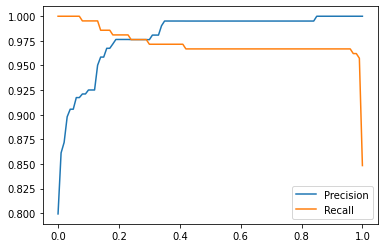

In [22]:
columns = ['threshold', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [23]:
# Answer to Question 2: The precision and recall graphs intersect at around 0.3 threshold.

### Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metric that takes into account both precision and recall.

This is the formula for computing F1: F1 = (2\*P\*R)/(P+R)

Where _P_ is precision and _R_ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

* 0.1
* 0.4
* 0.6
* 0.7

In [24]:
df_scores[ df_scores['f1'] == df_scores['f1'].max() ]

,threshold,precision,recall,f1
35,0.35,0.995146,0.971564,0.983213
36,0.36,0.995146,0.971564,0.983213
37,0.37,0.995146,0.971564,0.983213
38,0.38,0.995146,0.971564,0.983213
39,0.39,0.995146,0.971564,0.983213
40,0.40,0.995146,0.971564,0.983213
41,0.41,0.995146,0.971564,0.983213


In [25]:
# Answer to Question 4: F1 is maximal at threshold=0.4

### Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?
* 0.003
* 0.014
* 0.09
* 0.24

In [26]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards','active']

categorical = ['owner', 'selfemp']

df_full_train.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
710,0,1,36.83333,3.0000,0.000400,0.000000,yes,no,1,12,1,16
1258,1,0,35.58333,3.5606,0.109084,323.587500,no,no,0,12,1,0
435,1,0,25.66667,2.0000,0.004900,7.416667,no,no,0,26,1,13
987,0,0,25.58333,1.7500,0.000686,0.000000,no,no,0,108,0,0
1286,1,1,48.66667,6.0000,0.177017,885.085800,yes,no,3,114,1,19


In [27]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [28]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [29]:
#!pip install tqdm

In [30]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [32]:
n_splits=5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []
C=1.0

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores) ) )

C=1.0 0.996 +- 0.003


In [33]:
scores

[0.9941860465116279,
 0.9941176470588236,
 0.9943346508563901,
 0.9996107939802803,
 1.0]

In [34]:
# Answer to Question 5: standard deviation across the folds is 0.003

### Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: \[0.01, 0.1, 1, 10\]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.01
* 0.1
* 1
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.


In [39]:
n_splits=5


for C in tqdm([0.01, 0.1, 1, 10]): 
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%5s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores) ) )

  0%|          | 0/4 [00:00<?, ?it/s]

C= 0.01 0.992 +- 0.006
C=  0.1 0.995 +- 0.004
C=    1 0.996 +- 0.003
C=   10 0.996 +- 0.003


In [40]:
# Answer to Question 6: The smallest C which gives the best mean=0.996 is 1; it also gives the smallest std deviation=0.003.

In [41]:
0.84 - 0.836483

0.0035169999999999924

In [42]:
0.84 - 0.836967

0.0030329999999999524